In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from numpy.random import random, seed
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display
from scipy.stats import norm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression

In [79]:
#Here we will define the rigid regression function instead of using the function SKL
#Because we have a problem, where A singular matrix is very likely due to features that are very close to each other (or duplicates).
#Then I think to avoid such a problem we can define the rigid regression by our self

def Ridge_regression(X_train,X_test,z_train,z_test,lamb):
    df=pd.DataFrame(X_train)
    col=len(df.columns)
    I = np.eye(col,col)
    Ridgebeta = np.linalg.pinv(X_train.T @ X_train+lamb*I) @ X_train.T @ z_train
    z_train_pre = X_train @ Ridgebeta
    z_test_pre = X_test @ Ridgebeta
    return z_train_pre, z_test_pre


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def create_X(x, y, n=1 ):
    '''from x, y meshgrid vectors computes the design matrix for a polynomial model of degree n.'''
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    
    for i in range(1,n+1):
        #starting from the index after the i-1 degree
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            #combinations of powers of x and y, starting from x**i
            X[:,q+k] = (x**(i-k))*(y**k)
            
    # The design matrix is set up as 1,x,y,x**2,x*y,y**2
    return X

def OLS(X_train, X_test, z_train, z_test):
    '''
    Fit the model with OLS regression using the train set and 
    returns the predicted values for both the train and the test set.
    '''
    
    #extract regression coefficients
    beta_ols = np.linalg.pinv(X_train.T@X_train)@(X_train.T)@z_train
    
    #predict train and test values
    z_train_tilde_ols = X_train@beta_ols
    z_test_tilde_ols = X_test@beta_ols
    
    return z_train_tilde_ols, z_test_tilde_ols

#Important to split the data set before shuffling 
def bootstrap_OLS(X_train, X_test, z_train, z_test, n_bootstrap): 
    MSE = np.zeros((n_bootstrap,2))
    n = len(z_train)
    z_tilde_train_ols = np.empty((len(z_train), n_bootstrap))
    z_tilde_test_ols = np.empty((len(z_test), n_bootstrap))
    for i in range(n_bootstrap):
        sequence = np.random.randint(0,n,n)
        X1_train = X_train[sequence]
        z1_train = z_train[sequence]  
        z_tilde_train_ols[:,i] , z_tilde_test_ols[:,i] = OLS(X1_train, X_test, z1_train, z_test) 
        MSE[i,0] = mean_squared_error(z1_train,z_tilde_train_ols[:,i]) 
        MSE[i,1] = mean_squared_error(z_test,z_tilde_test_ols[:,i])  
    return z_tilde_train_ols, z_tilde_test_ols, MSE
# From now on, index 0 corresponds to train and 1 to test

def cross_validation_OLS(k_folds, X, z):
    MSE_train = []
    MSE_test = []
    kfold = KFold(n_splits = k_folds)
    for train_inds, test_inds in kfold.split(X):
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]

        z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test)
        
        MSE_train.append(mean_squared_error(z_train, z_train_tilde_ols))
        MSE_test.append(mean_squared_error(z_test, z_test_tilde_ols))
        
    MSE_train_mean = np.mean(MSE_train)
    MSE_test_mean = np.mean(MSE_test)
    return MSE_train_mean, MSE_test_mean

def Ridge(X_train,X_test,z_train,z_test,lambd):

    # Since it relates to remove intercepts, better to use built in function in SKL
    RegRidge = linear_model.Ridge(lambd,fit_intercept= True, solver = "lsqr")
    
    #fit the model to the training data
    RegRidge.fit(X_train,z_train)
    
    # and then make the prediction
    z_tilde_train = RegRidge.predict(X_train)
    z_tilde_test = RegRidge.predict(X_test)
    
    return z_tilde_train, z_tilde_test

#Important to split the data set before shuffling 
def bootstrap_Ridge(X_train, X_test, z_train, z_test, n_bootstrap, lambd): 
    
    #prepare arrays for output
    MSE = np.zeros((n_bootstrap,2))
    z_tilde_train = np.zeros((len(z_train), n_bootstrap))
    z_tilde_test = np.zeros((len(z_test), n_bootstrap))
    
    n = len(z_train)
    
    #cycle on resamplings
    for i in range(n_bootstrap):
        
        #extract sequence for resampling
        sequence = np.random.randint(0,n,n)
        
        #resampled arrays
        X1_train = X_train[sequence]
        z1_train = z_train[sequence]
        
        #fit and predict
        z_tilde_train[:,i], z_tilde_test[:,i] = Ridge_regression(X1_train, X_test, z1_train, z_test, lambd)
        
        #calculate mse on train and test
        MSE[i,0] = mean_squared_error(z1_train,z_tilde_train[:,i])
        MSE[i,1] = mean_squared_error(z_test,z_tilde_test[:,i])

    return z_tilde_train, z_tilde_test, MSE

def cross_validation_Ridge(k_folds, X, z, lambd):
    MSE_train = []
    MSE_test = []
    kfold = KFold(n_splits = k_folds)
    for train_inds, test_inds in kfold.split(X):
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]

        z_train_tilde_Ridge, z_test_tilde_Ridge = Ridge_regression( X_train, X_test, z_train, z_test, lambd)
        
        MSE_train.append(mean_squared_error(z_train, z_train_tilde_Ridge))
        MSE_test.append(mean_squared_error(z_test, z_test_tilde_Ridge))
    MSE_train_mean = np.mean(MSE_train)
    MSE_test_mean = np.mean(MSE_test)
    return MSE_train_mean, MSE_test_mean

In [5]:
#We have to discuss the value of threshold that we have set for creating our input  data to create the desigen matrix

In [6]:
boston_data = load_boston()
boston_df = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
boston_df['MEDV'] = boston_data.target
features = boston_df.columns.tolist() 
print(features[:-1])
print(boston_df)


['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
        CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0    0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1    0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2    0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3    0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4    0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
501  0.06263   0.0  11.93   0.0  0.573  6.593  69.1  2.4786  1.0  273.0   
502  0.04527   0.0  11.93   0.0  0.573  6.120  76.7  2.2875  1.0  273.0   
503  0.06076   0.0  11.93   0.0  0.573  6.976  91.0  2.1675  1.0  273.0   
504  0.10959   0.0  11.93   0.0  0.573  6.794  89.3  2.3889  1.0  273.0   
505  0.04741   0.0  11.93   0.0  0.573  6.030  80.8  2.5050  1.0  273.0   

 

In [7]:
def drop_columns(array_corr,thres_corr):
    ''' Function takes in a value of thresholding and return the filtered dataframe, excluding already the target columns'''
    thresh_index = np.where((array_corr> thres_corr) == False)
    col_indi = np.append(thresh_index[0],13) # add target column
    filtered_boston = boston_df.drop(boston_df.columns[col_indi], axis=1)  
    return filtered_boston

In [9]:
#Here we dfeine arrat_corr
corr_matrix = boston_df.corr().round(2)
array_corr = corr_matrix["MEDV"].abs()

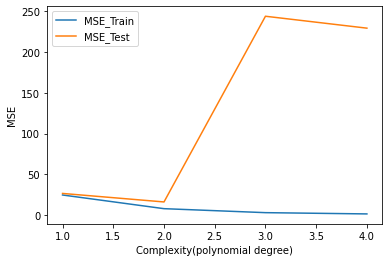

In [24]:
#### degree of the polynomial model
maxdegree = 4

#target feature
z = boston_df['MEDV']
x = boston_df[features[:-1]] # original features

polydegree = np.zeros(maxdegree)
MSE_OLS = np.zeros((maxdegree,2))
R2_OLS=np.zeros((maxdegree,2))

x = drop_columns(array_corr,0.3)
#Here we have different results depending on the threshold value where 0.3 much worse compaire to 0.4

for degree in range(maxdegree):
    poly = PolynomialFeatures(degree+1)
    
    X = poly.fit_transform(x)
    
    X_train, X_test, z_train, z_test = train_test_split(np.array(X), np.array(z), test_size=0.3, random_state = 2)
    
   
    polydegree[degree] = degree+1
    
    z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test) 
    
    MSE_OLS[degree, 0] = mean_squared_error(z_train,z_train_tilde_ols)
    MSE_OLS[degree, 1] = mean_squared_error(z_test,z_test_tilde_ols)  
    R2_OLS[degree,0]= r2_score(z_train,z_train_tilde_ols)
    R2_OLS[degree,1]= r2_score(z_test,z_test_tilde_ols)
    
#plot the results
plt.plot(polydegree,MSE_OLS[:,0],label='MSE_Train')
plt.plot(polydegree,MSE_OLS[:,1],label='MSE_Test')
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
#plt.ylim(0,50)
#plt.yscale("log")
plt.legend()
plt.show()


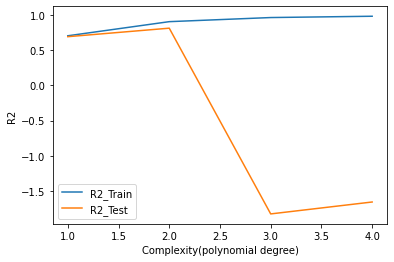

In [25]:
#R2-Plots 
plt.plot(polydegree,R2_OLS[:,0],label='R2_Train')
plt.plot(polydegree,R2_OLS[:,1],label='R2_Test')
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('R2')
plt.legend()
plt.show()

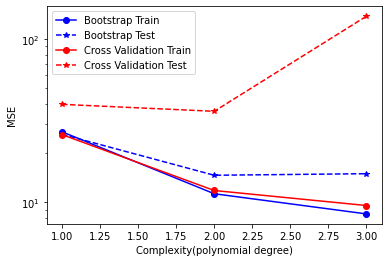

In [26]:
#degree of the polynomial model
maxdegree = 3

n_bs = 200

k_folds = 6

#target feature
z = boston_df['MEDV']
x = boston_df[features[:-1]] # original features

x = drop_columns(array_corr,0.4)

polydegree = np.zeros(maxdegree)
MSE_boot = np.zeros((maxdegree,2))
MSE_cv = np.zeros((maxdegree,2))
for degree in range(maxdegree):
    
    #set up the model
    poly = PolynomialFeatures(degree+1)
    
    X = poly.fit_transform(x)
    
    X_train, X_test, z_train, z_test = train_test_split(np.array(X), np.array(z), test_size=0.3, random_state = 2)
    
    #z_t = z_test.reshape(len(z_test),1)
    polydegree[degree] = degree+1
    
    z_train_tilde_ols , z_test_tilde_ols, MSE_boot_deg = bootstrap_OLS(X_train, X_test, z_train, z_test, n_bs) 
    
    MSE_boot[degree, 0] = np.mean(MSE_boot_deg[:,0])
    MSE_boot[degree, 1] = np.mean(MSE_boot_deg[:,1])
    
    MSE_cv[degree, 0], MSE_cv[degree, 1] = cross_validation_OLS(k_folds,X,z)
     

#plot the results
plt.plot(polydegree,MSE_boot[:,0],"bo-",label='Bootstrap Train')
plt.plot(polydegree,MSE_boot[:,1],"b*--",label='Bootstrap Test')
plt.plot(polydegree,MSE_cv[:,0],"ro-",label='Cross Validation Train')
plt.plot(polydegree,MSE_cv[:,1],"r*--",label='Cross Validation Test')
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.yscale("log")
plt.legend()
plt.show()

Lambda to obtain miminum MSE: 1128.84


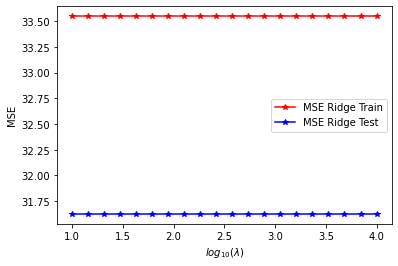

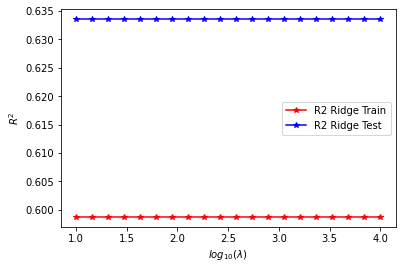

In [80]:
#Let's apply the rigid regression
#First the number of lambdas we will consider 
maxdegree= 4
nlambdas = 20 
lambd = np.logspace(1, 4, nlambdas)

z = boston_df['MEDV']
x = boston_df[features[:-1]] # original features

x = drop_columns(array_corr,0.3)
polydegree = np.zeros(maxdegree)
MSE_Ridge = np.zeros((len(lambd),2))
R2_Ridge = np.zeros((len(lambd),2))

#Here 0.5 gives much better result compaire with 0.4 and 0.3 
for degree in range(maxdegree):
    
    #set up the model
    poly = PolynomialFeatures(degree+1)
    
    X = poly.fit_transform(x)
    

    polydegree[degree] = degree+1
    X_train, X_test, z_train, z_test = train_test_split(np.array(X), np.array(z), test_size=0.3, random_state = 2)

    for i in range(nlambdas):
        z_tilde_train, z_tilde_test = Ridge(X_train,X_test,z_train,z_test,lambd[i])
        MSE_Ridge[i,0] = mean_squared_error(z_train, z_tilde_train)
        MSE_Ridge[i,1] = mean_squared_error(z_test, z_tilde_test)
        R2_Ridge[i, 0] = r2_score(z_train, z_tilde_train)
        R2_Ridge[i, 1] = r2_score(z_test, z_tilde_test)
        
plt.figure()
plt.plot(np.log10(lambd), MSE_Ridge[:,0], 'r*-', label = 'MSE Ridge Train')
plt.plot(np.log10(lambd), MSE_Ridge[:,1], 'b*-', label = 'MSE Ridge Test')
plt.xlabel('$log_{10}(\lambda)$')
plt.ylabel('MSE')
plt.legend()
print('Lambda to obtain miminum MSE: {:.2f}'.format(lambd[np.argmin(MSE_Ridge[:,1])]))
plt.show()

plt.figure()
plt.plot(np.log10(lambd), R2_Ridge[:,0], 'r*-', label = 'R2 Ridge Train')
plt.plot(np.log10(lambd), R2_Ridge[:,1], 'b*-', label = 'R2 Ridge Test')
plt.xlabel('$log_{10}(\lambda)$')
plt.ylabel('$R^2$')
plt.legend()
plt.show()

In [62]:
#Bootstrap-Rigide
maxdegree = 12
lambd = 428.133240
n_bootstrap = 100
error_ols = np.zeros(maxdegree)
bias_ols = np.zeros(maxdegree)
variance_ols = np.zeros(maxdegree)

error_ridge = np.zeros(maxdegree)
bias_ridge = np.zeros(maxdegree)
variance_ridge = np.zeros(maxdegree)

polydegree = np.zeros(maxdegree)

MSE_boot_ridge = np.zeros((maxdegree,2))

for degree in range(maxdegree):
    
    poly = PolynomialFeatures(degree+1)
    
    X = poly.fit_transform(x)

    
    #train-test split
    X_train, X_test, z_train, z_test = train_test_split(np.array(X), np.array(z), test_size=0.3, random_state = 2)
 
    z_train_ridge, z_pred_ridge, mse_ridge = bootstrap_Ridge(X_train, X_test, z_train, z_test, n_bootstrap, lambd)
    
    #reshape test values
    z_t = z_test.reshape(len(z_test),1)
    polydegree[degree] = degree + 1
    
    #calculate error, bias, variance for Ridge regression
    error_ridge[degree] = np.mean( np.mean((z_t - z_pred_ridge)**2, axis=1, keepdims=True) )
    bias_ridge[degree] = np.mean( (z_t - np.mean(z_pred_ridge, axis=1, keepdims=True))**2 )
    variance_ridge[degree] = np.mean( np.var(z_pred_ridge, axis=1, keepdims=True) )
    MSE_boot_ridge[degree, 0] = np.mean(mse_ridge[:,0]) 
    MSE_boot_ridge[degree, 1] = np.mean(mse_ridge[:,1]) 
    

plt.plot(polydegree, error_ridge, "g", label='Error Ridge')
plt.plot(polydegree, bias_ridge, "b", label='Bias Ridge')
plt.plot(polydegree, variance_ridge, "r", label='Variance Ridge')

plt.xlabel('Complexity(polynomial degree)')

#plt.yscale("log")

plt.legend()
plt.show()

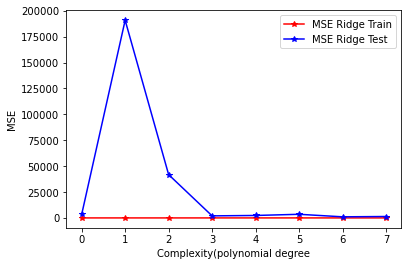

In [78]:
#Cross-Validation
maxdegree=12
k_folds = range(5,13)
MSE_cross_Ridge = np.zeros((len(k_folds),2))

z = boston_df['MEDV']
x = boston_df[features[:-1]] # original features

lambd = 428.133240

x = drop_columns(array_corr,0.5)


for degree in range(maxdegree):
    
    poly = PolynomialFeatures(degree+1)
    
    X = poly.fit_transform(x)
    for k in range(len(k_folds)):
        MSE_cross_Ridge[k,0], MSE_cross_Ridge[k,1] = cross_validation_Ridge(k_folds[k],X,z,lambd)

plt.plot(MSE_cross_Ridge[:,0], 'r*-', label = 'MSE Ridge Train')
plt.plot(MSE_cross_Ridge[:,1], 'b*-', label = 'MSE Ridge Test')
plt.xlabel('Complexity(polynomial degree')
plt.ylabel('MSE')
plt.legend()